In [68]:
import random
import json
import re
import os
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

random.seed(6)
np.random.seed(6)

WORK_DIR = Path.cwd().parent


# Experiment - VQA with video frames
## Llama3.2 8b on chat mode


## Prompts

In [69]:
with open(WORK_DIR / 'data/prompts/img_answer/user_prompt.txt', 'r') as f:
    pr = f.read()

print(pr)


You will receive a sequence of images and a question related to them. Analyze the images in the order they are presented,\
extract relevant details, and identify any patterns, changes, or relationships between them. Use this information to provide\
a choose one of the presented alternatives

Instructions:
- Describe each image in the sequence briefly but meaningfully.
- Note any important transitions or developments between consecutive images.
- Combine observations to infer the overall context or narrative.
- Answer the question based on your analysis, ensuring your response is grounded in the visual evidence.
- Read the question and reason about the answer step by step.
- In your answer include key events or relationships that help you in determine the correct answer.
- Be careful to reproduce the chosen alternative as it is presented.

Q: {question}
<Alternatives>
A. {c1}
B. {c2}
C. {c3}
D. {c4}
</Alternatives>


In [70]:
reply = """\
Therefore the final answer is?

Your response must be provided in valid JSON format as follows:
{"answer": "your complete answer here"}

IMPORTANT: Always include both the letter (A, B, C, D, etc.) AND the full text of the answer in your response.
Do not abbreviate or shorten the answer. For example, if the correct answer is "A. the laptop", your response 
should be {"answer": "A. the laptop"}, not {"answer": "laptop"} or {"answer": "A"}.\
"""

print(reply)


Therefore the final answer is?

Your response must be provided in valid JSON format as follows:
{"answer": "your complete answer here"}

IMPORTANT: Always include both the letter (A, B, C, D, etc.) AND the full text of the answer in your response.
Do not abbreviate or shorten the answer. For example, if the correct answer is "A. the laptop", your response 
should be {"answer": "A. the laptop"}, not {"answer": "laptop"} or {"answer": "A"}.


Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [71]:
ground_truth = []

with open(WORK_DIR / 'data/datasets/STAR_QA_and_stsg_val.json') as f:
    data = json.load(f)
    ground_truth = [{
        'id': sample['question_id'],
        'question': sample['question'],
        'choices': sample['choices'],
        'num': sample['answer'],
        'text': sample['choices'][str(sample['answer'])],
        'stsg': sample['stsg'],
    } for sample in data]


# we keep num as str so we can directrly access choices dictionaries
gt_df = pd.DataFrame(ground_truth).astype({'id': 'string', 'num': 'string', 'text': 'string'})
gt_df.set_index('id', inplace=True)
gt_df


,question,choices,num,text,stsg
id,,,,,
Interaction_T1_13,Which object was tidied up by the person?,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.,"[[person - on_the_side_of - clothes], [person ..."
Interaction_T1_14,Which object was tidied up by the person?,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.,"[[person - holding - towel, person - in_front_..."
Interaction_T1_31,Which object was thrown by the person?,"{'0': 'The pillow.', '1': 'The bag.', '2': 'Th...",2,The clothes.,"[[person - wearing - clothes, person - above -..."
Interaction_T1_32,Which object was put down by the person?,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.,"[[person - on_the_side_of - clothes, person - ..."
Interaction_T1_40,Which object was tidied up by the person?,"{'0': 'The broom.', '1': 'The closet/cabinet.'...",1,The closet/cabinet.,"[[person - holding - clothes, person - in_fron..."
...,...,...,...,...,...
Feasibility_T6_1453,What is the person able to do after taking the...,"{'0': 'Wash the table.', '1': 'Take the box.',...",0,Wash the table.,"[[person - on_the_side_of - table, person - ho..."
Feasibility_T6_1454,What is the person able to do after walking th...,"{'0': 'Take the towel.', '1': 'Throw the bag.'...",0,Take the towel.,"[[person - in_front_of - table], [person - in_..."
Feasibility_T6_1455,What is the person able to do after walking th...,"{'0': 'Throw the bag.', '1': 'Wash the table.'...",1,Wash the table.,"[[person - in_front_of - table], [person - in_..."


## Loading predicted answers evaluation

In [72]:
predictions = []
with open(WORK_DIR / 'outputs/responses_llama3.1:8b_VQA_20250502_23:17:99.jsonl', mode='r', encoding='utf-8', errors='strict') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id'})
predictions_df.set_index('id', inplace=True)
predictions_df



,chat_history
id,
Interaction_T3_2531,"[{'role': 'user', 'content': ' You will rec..."
Interaction_T1_2219,"[{'role': 'user', 'content': ' You will rec..."
Sequence_T4_1348,"[{'role': 'user', 'content': ' You will rec..."
Sequence_T4_4702,"[{'role': 'user', 'content': ' You will rec..."
Sequence_T1_3418,"[{'role': 'user', 'content': ' You will rec..."
...,...
Sequence_T2_2783,"[{'role': 'user', 'content': ' You will rec..."
Sequence_T3_1333,"[{'role': 'user', 'content': ' You will rec..."
Interaction_T2_6458,"[{'role': 'user', 'content': ' You will rec..."


In [73]:
predictions_df['chat_history'] = \
    predictions_df['chat_history'] \
    .apply(lambda x: eval(x))

predictions_df


,chat_history
id,
Interaction_T3_2531,"[{'role': 'user', 'content': ' You will rec..."
Interaction_T1_2219,"[{'role': 'user', 'content': ' You will rec..."
Sequence_T4_1348,"[{'role': 'user', 'content': ' You will rec..."
Sequence_T4_4702,"[{'role': 'user', 'content': ' You will rec..."
Sequence_T1_3418,"[{'role': 'user', 'content': ' You will rec..."
...,...
Sequence_T2_2783,"[{'role': 'user', 'content': ' You will rec..."
Sequence_T3_1333,"[{'role': 'user', 'content': ' You will rec..."
Interaction_T2_6458,"[{'role': 'user', 'content': ' You will rec..."


In [74]:
predictions_df['answer'] = predictions_df['chat_history'].apply(lambda x: x[-1]['content'])
# Create mask for answers that follow JSON syntax
json_mask = predictions_df['answer'] .str.match(r'^\s*{[^}]+}\s*$')
matches_json_template = json_mask.sum()

print(f"Total answers: {len(predictions_df)}")
print(f"Answers following JSON template: {matches_json_template}")
print(f"Percentage following JSON template: {(matches_json_template/len(predictions_df))*100:.2f}%")


Total answers: 6104
Answers following JSON template: 6069
Percentage following JSON template: 99.43%


Here we have wrong formantting, regardless of the correctness of the answer

In [75]:
predictions_df[~json_mask]['answer'].iloc[0]


'Since I don\'t have the images to analyze, I\'ll provide a generic response.\n\n{"answer": "I\'m unable to determine the correct answer without analyzing the images."}'

In [76]:
predictions_df[~json_mask]['answer'].iloc[1]


'{"answer": "B. The clothes."} \n\nHowever, I must note that there is no image of clothes in the sequence provided. My previous analysis was based on the assumption that the person put down both the bag and the towel, but since the question asks which object was put down by the person, it\'s likely that the correct answer is indeed one of these two objects.\n\nGiven the images, I would have expected the correct answer to be either "A. The pillow" (which was not my initial conclusion) or "D. The bag".'

In [77]:
eval(predictions_df[json_mask]['answer'].iloc[0])['answer']


'C. Opened the bag.'

In [78]:
predictions_df.loc[json_mask, 'answer'] = predictions_df.loc[json_mask, 'answer'].apply(lambda x: eval(x)['answer'].strip())
predictions_df.loc[~json_mask, 'answer'] = ""


In [79]:
ans_regex_pattern = r'^(?:[A-Z]\.)\s+((?:\w+(?:\s|\/)?){,10}\.?)'
contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, regex=True)

print(f"Answer following the template: {contains_answer.value_counts()[True]}\n"
      f"{contains_answer.value_counts()[True]/predictions_df.shape[0]:.2%} of the total")

print(f"\nOnly {contains_answer.value_counts()[False]} samples do not contain the answer in the response with the specified format")


Answer following the template: 6062
99.31% of the total

Only 42 samples do not contain the answer in the response with the specified format


/tmp/ipykernel_5108/3127831504.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, regex=True)


In [80]:
predictions_df.loc[~contains_answer, 'answer']


id
Interaction_T4_3321    None of the above alternatives can be accurate...
Interaction_T4_1122                                                     
Interaction_T1_4495                                                     
Interaction_T2_2582                                                     
Feasibility_T2_374                                                      
Interaction_T1_4980                                                     
Sequence_T4_1824       There is insufficient information to determine...
Interaction_T4_476     None of the provided alternatives directly mat...
Interaction_T4_4728                                                     
Interaction_T4_4253                                   None of the above.
Sequence_T5_1101                                                        
Interaction_T2_3824                                                     
Interaction_T1_7185                                                     
Interaction_T2_8090                             

In [81]:
gt_df


,question,choices,num,text,stsg
id,,,,,
Interaction_T1_13,Which object was tidied up by the person?,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.,"[[person - on_the_side_of - clothes], [person ..."
Interaction_T1_14,Which object was tidied up by the person?,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.,"[[person - holding - towel, person - in_front_..."
Interaction_T1_31,Which object was thrown by the person?,"{'0': 'The pillow.', '1': 'The bag.', '2': 'Th...",2,The clothes.,"[[person - wearing - clothes, person - above -..."
Interaction_T1_32,Which object was put down by the person?,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.,"[[person - on_the_side_of - clothes, person - ..."
Interaction_T1_40,Which object was tidied up by the person?,"{'0': 'The broom.', '1': 'The closet/cabinet.'...",1,The closet/cabinet.,"[[person - holding - clothes, person - in_fron..."
...,...,...,...,...,...
Feasibility_T6_1453,What is the person able to do after taking the...,"{'0': 'Wash the table.', '1': 'Take the box.',...",0,Wash the table.,"[[person - on_the_side_of - table, person - ho..."
Feasibility_T6_1454,What is the person able to do after walking th...,"{'0': 'Take the towel.', '1': 'Throw the bag.'...",0,Take the towel.,"[[person - in_front_of - table], [person - in_..."
Feasibility_T6_1455,What is the person able to do after walking th...,"{'0': 'Throw the bag.', '1': 'Wash the table.'...",1,Wash the table.,"[[person - in_front_of - table], [person - in_..."


## Extract answers

In [82]:
ans_df = \
    predictions_df[contains_answer]['answer'] \
    .apply(lambda x: re.findall(ans_regex_pattern, x)[-1]) \
    .apply(lambda x: x + '.' if not x.endswith('.') else x) \
    .to_frame(name='text')

ans_df.rename(columns={0: 'text'}, inplace=True)

ans_df['text'] = ans_df['text'].str.strip()
ans_df


,text
id,
Interaction_T3_2531,Opened the bag.
Interaction_T1_2219,The paper/notebook.
Sequence_T4_1348,Sat on the sofa/couch.
Sequence_T4_4702,Put down the cup/glass/bottle.
Sequence_T1_3418,The blanket.
...,...
Sequence_T2_2783,The dish.
Sequence_T3_1333,Took the shoe.
Interaction_T2_6458,Opened.


In [83]:
ans_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6062 entries, Interaction_T3_2531 to Interaction_T3_3436
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6062 non-null   object
dtypes: object(1)
memory usage: 94.7+ KB


In [84]:
freq = ans_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

print(f"We have {freq.size} unique answers")


We have 440 unique answers


In [85]:
ans_df['text'].value_counts()


text
Put down.                                                334
The cup/glass/bottle.                                    262
Opened.                                                  249
The bag.                                                 198
The phone/camera.                                        197
                                                        ... 
Sit on the floor.                                          1
The mirror.                                                1
Took the shoe with them as they moved through their .      1
Sat on the laptop.                                         1
Took the pillow with them when they got up from .          1
Name: count, Length: 220, dtype: int64

<Axes: xlabel='freq', ylabel='word'>

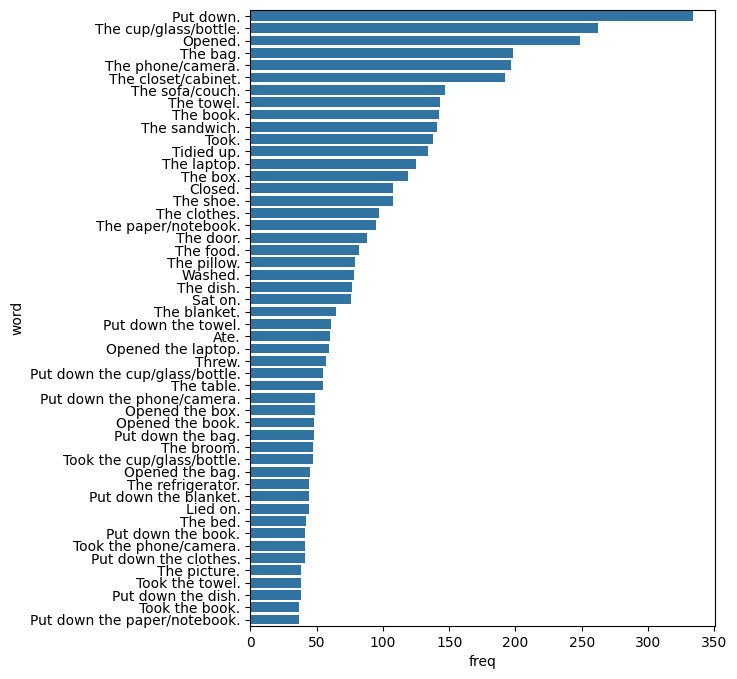

In [86]:
plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


Let's do some visualization also for the ground truth data

In [87]:
print(f"We have {gt_df['text'].nunique()} unique answers")


We have 198 unique answers


<Axes: xlabel='freq', ylabel='word'>

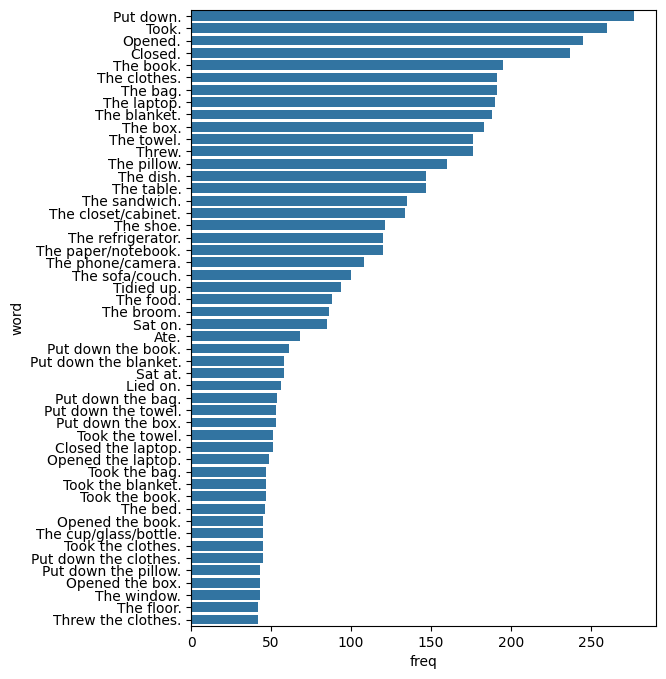

In [88]:
freq = gt_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


In [89]:
# Inner join - keeps only indices present in both series

ans_df.rename(columns={'text': 'pred_text'}, inplace=True)
eval_df = gt_df.join(
    ans_df, 
    how='inner' # we account also for samples without answers
)

eval_df.shape


(6062, 6)

In [90]:
def accuracy(eval_df, on_what='text'):
    hits_text = (eval_df[f'pred_{on_what}'].str.lower() == eval_df[on_what].str.lower()).sum()
    

    return hits_text/eval_df.shape[0]


check if the equality with NA result in a false or is skipped

In [91]:
real_acc = accuracy(eval_df) * eval_df.shape[0] / gt_df.shape[0]

print(f"Real Accuracy: {real_acc:.2%}")


Real Accuracy: 25.47%


In [92]:
def print_acc(eval_df, acc_fn):
    print(f"{'Question type':<15}{'Total':^15}{'Accuracy':^10}\n")

    total = eval_df.index.str.startswith('Interaction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Interaction')])
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Sequence').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Sequence')])
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Prediction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Prediction')])
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Feasibility').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Feasibility')])
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")


In [93]:
print_acc(eval_df, lambda x: accuracy(x, on_what='text'))


Question type       Total      Accuracy 

Interaction         2051        28.91%  
Sequence            3061        30.64%  
Prediction           533        30.02%  
Feasibility          417        28.06%  


In [94]:
# % of answers conforming to template per category

def print_ans_perc(eval_df, gt_df):
    print(f"{'Question type':<15}{'Total':^15}{'Answered':^10}\n")

    total = gt_df.index.str.startswith('Interaction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Interaction')].index))/total
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Sequence').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Sequence')].index))/total
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Prediction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Prediction')].index))/total
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Feasibility').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Feasibility')].index))/total
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.shape[0]
    acc = eval_df.shape[0]/total
    print(f"{'Overall':<15}{total:^15}{acc:^10.2%}")

print_ans_perc(eval_df, gt_df)


Question type       Total      Answered 

Interaction         2398        85.53%  
Sequence            3586        85.36%  
Prediction           624        85.42%  
Feasibility          490        85.10%  
Overall             7098        85.40%  


In [103]:
predictions_df.iloc[0]['chat_history']


[{'role': 'user',
  'content': '    You will receive a sequence of images and a question related to them. Analyze the images in the order they are presented,    extract relevant details, and identify any patterns, changes, or relationships between them. Use this information to provide    a choose one of the presented alternatives\n\n    Instructions:\n    - Describe each image in the sequence briefly but meaningfully.\n    - Note any important transitions or developments between consecutive images.\n    - Combine observations to infer the overall context or narrative.\n    - Answer the question based on your analysis, ensuring your response is grounded in the visual evidence.\n    - Read the question and reason about the answer step by step.\n    - In your answer include key events or relationships that help you in determine the correct answer.\n    - Be careful to reproduce the chosen alternative as it is presented.\n\n    Q: What did the person do while they were holding the bag?\n  

In [104]:
import sys

sys.path.append(str(WORK_DIR / 'src'))


In [105]:
import main


In [ ]:
frame_count = {}

for frames in main.generate_frames():
    id = frames[0]['question_id']
    frame_count[id] = len(frames)
    

count_series = pd.Series(frame_count)
count_series.describe()


count    7098.000000
mean        8.414624
std         1.346262
min         4.000000
25%         8.000000
50%         9.000000
75%         9.000000
max        10.000000
dtype: float64

<Axes: ylabel='Count'>

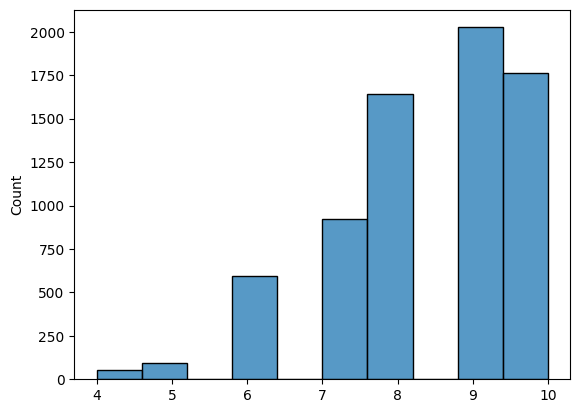

In [ ]:
sns.histplot(count_series, bins=10)
